In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_ROBOT = False
CONNECT_MOBILE = False
SAVE_DATA = False

MOBILE_IP = "192.168.17.2"
ROBOT_IP = "192.168.17.2"
PANDA_IP = "192.168.17.3"

print("Mobile IP: {}".format(MOBILE_IP))
print("ROBOT  IP: {}".format(ROBOT_IP))
print("PANDA  IP: {}".format(PANDA_IP))

sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/developing/multiobject'))

from concurrent import futures
import logging
import math
import time
import cv2
import numpy as np
import grpc
import RemoteCam_pb2
import RemoteCam_pb2_grpc

MAX_MESSAGE_LENGTH = 10000000
PORT_CAM = 10509

Mobile IP: 192.168.17.2
ROBOT  IP: 192.168.17.2
PANDA  IP: 192.168.17.3


In [2]:
from enum import Enum
class ExpType(Enum):
    REMOVE_OBS=0
    CONTACT_TAR=1

EXP_SCENARIO = ExpType.CONTACT_TAR

In [3]:
ROBOT_BASE_OFFSET = (0,0,0.592)
ROBOT_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.7
COL_COLOR = (1,1,1,0.2)
    
if EXP_SCENARIO == ExpType.REMOVE_OBS: ## Obstacle removing
    BAG_COUNT = 5
    CLOCK_COUNT = 0
    TARGET_COUNT = 5
    LOG_FORCE = False
else: ## Contact 
    BAG_COUNT = 3
    CLOCK_COUNT = 3
    TARGET_COUNT = 5
    LOG_FORCE = True

from pkg.controller.combined_robot import *
from pkg.project_config import *

kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.pmb, ((0,0,0), (0,0,0)), MOBILE_IP)
robot_config = RobotConfig(1, RobotType.panda_arm, 
                           (ROBOT_BASE_OFFSET, ROBOT_BASE_RPY),
                           "{}/{}".format(ROBOT_IP, PANDA_IP), root_on="pmb0_platform")

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config],
                     connection_list=[CONNECT_MOBILE, CONNECT_ROBOT])

connection command:
pmb0: False
panda_arm1: False


### Make scene

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

gscene.set_workspace_boundary(
    -1, 4, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

gscene.show_pose(crob.home_pose)
crob.simulator.gscene=gscene

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Planning scene

In [5]:
from pkg.geometry.geometry import *
from pkg.utils.code_scraps import *
from pkg.planning.constraint.constraint_subject import *
from pkg.planning.constraint.constraint_actor import *
from exp_config import *

pscene = PlanningScene(gscene, combined_robot=crob)

In [6]:
ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE
BRUSH_NAME = "brush_face"
theta = -np.pi*3/4
viewpoint  = add_panda_cam(gscene, tool_link=TIP_LINK, theta=theta)
brush_face = add_panda_brush(gscene, tool_link=TIP_LINK, theta=theta, brush_name=BRUSH_NAME)

point_brush, rpy_brush = (0,0,-brush_face.dims[2]/2), (0,0,0)
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayFramer, point=point_brush, rpy=rpy_brush)
gscene.show_pose(crob.home_pose)

MOBILE_PUSH_NAME = "mpush"
MOBILE_PUSH_HEIGHT = 0.4
MOBILE_PUSH_KEY = 1
MOBILE_SLIDE_KEY = 2
front_dist = 0.31
mpush_g = gscene.create_safe(GEOTYPE.SPHERE, MOBILE_PUSH_NAME, link_name=HOLD_LINK,dims=(0.01,0.01,0.01),
                           center=(front_dist, 0, MOBILE_PUSH_HEIGHT), rpy=(0,np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5))
mpush_b = pscene.create_binder(MOBILE_PUSH_NAME, MOBILE_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=MOBILE_PUSH_KEY)

floor_b = pscene.create_binder("floor_ws", "floor_ws", PlaceFrame, point=(0,0,WALL_THICKNESS/2), key=MOBILE_SLIDE_KEY)

TOOL_PUSH_NAME = "tpush"
TOOL_PUSH_HEIGHT = 0.03
TOOL_PUSH_KEY = 10
TOOL_SLIDE_KEY = 11
brush_col = gscene.NAME_DICT[BRUSH_NAME+"_col"]
TOOL_DIM = brush_col.dims

center_push, rpy_push = (TOOL_DIM[0]/2+CLEARANCE, 0, 0), (0,np.pi/2,0)    
tpush_g = gscene.create_safe(GEOTYPE.SPHERE, TOOL_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=center_push, rpy=rpy_push,
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
tpush_b = pscene.create_binder(TOOL_PUSH_NAME, TOOL_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=TOOL_PUSH_KEY)

### MultiICP Detector

In [7]:
from pkg.detector.multiICP.multiICP import MultiICP, MultiICP_Obj
from pkg.detector.multiICP.config import *
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

import open3d as o3d
import numpy as np

CONNECT_CAM = False
REMOTE_CAM = True

CARRIER_DIM = (0.4, 0.29, 0.635)
CLOCK_DIM = (0.138, 0.05, 0.078)
TABLE_DIM = (1.6, 0.8, 0.725)

In [8]:
from demo_utils.data_reconstructed_camera import DataRecontructedCamera
dcam = DataRecontructedCamera(crob, viewpoint)
# if not CONNECT_CAM and not REMOTE_CAM:
#     dcam.initialize()

if CONNECT_CAM:
    realsense = RealSense()
    micp = MultiICP(realsense)
    micp.initialize()
else:
    if REMOTE_CAM:
        # use remote camera
        micp = MultiICP(None)
        micp.initialize(remote_cam=REMOTE_CAM)
        dcam.ready_saving(*micp.get_camera_config())
        cam_pose = viewpoint.get_tf(VIEW_POSE_EXT)
    else:
        # use manually given camera configs
        micp = MultiICP(None)
        config_list, img_dim = load_pickle(RNB_PLANNING_DIR+"release/multiICP_data/cam_configs.pkl")
        micp.initialize(config_list, img_dim)
#         micp = MultiICP(dcam)
#         micp.initialize()

Camera is not set - skip initialization, use remote camera
request 0 -> response 0
==== Received camera config from remote camera ====


### Shared Detector

In [9]:
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")

from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(tuple(reversed(micp.dsize))+(3,))()
sd.init()

### Set ICP Config

In [10]:
# Load config file of object information
obj_info_dict = get_obj_info()

In [11]:
micp_suitcase = MultiICP_Obj(obj_info_dict["suitcase"], None,
                        OffsetOnModelCoord("suitcase", R=np.matmul(Rot_axis(1, np.pi/2), Rot_axis(3, np.pi/2)), offset=(0.,0.,0.11)))


micp_clock = MultiICP_Obj(obj_info_dict["clock"], None,
                        OffsetOnModelCoord("clock", R=Rot_axis(1, np.pi/2), offset=(-0.07,0.03,0.)))


micp_table = MultiICP_Obj(obj_info_dict["dining table"], None,
                        OffsetOnModelCoord("dining table", R=Rot_axis(1, 3*np.pi/4), offset=(0.,0.35,0.6)))

In [12]:
micp_dict = {"suitcase": micp_suitcase, "clock": micp_clock, "dining table": micp_table}
micp.set_config(micp_dict, sd, crob, viewpoint)

## Table

In [13]:
VIEW_LOC = crob.get_real_robot_pose()[:6]
VIEW_ARM = crob.home_pose[6:] + np.deg2rad([0,0,0,0,0,45,-45])
VIEW_TABLE = list(VIEW_LOC) + list(VIEW_ARM)
crob.joint_move_make_sure(np.array(VIEW_TABLE), ref_speed=np.pi/10)

In [14]:
TABLE_DIM = (0.6, 1.2, 0.7)
TABLE_NAME = "table"
TABLE_LOC = (3, 0, TABLE_DIM[2]/2)
TABLE_RPY = (0,0,0)

In [15]:
table_g = gscene.create_safe(GEOTYPE.BOX, TABLE_NAME, link_name="base_link", dims=TABLE_DIM,
                             center=TABLE_LOC, rpy=TABLE_RPY,
                             fixed=True, collision=True, color=(0.8,0.8,0.8,1))
table_b = pscene.create_binder(TABLE_NAME, TABLE_NAME, PlaceFrame, point=(0,0,TABLE_DIM[2]/2), key=TOOL_SLIDE_KEY)
gscene.add_virtual_guardrail(table_g, HEIGHT=0.01, axis="xy")

In [16]:
# for dining table
micp.set_ICP_thres(thres_ICP=0.6, thres_front_ICP=0.18)
# micp.set_multiobject_num(num = 1)
micp.set_merge_mask(merge=True)
pose_dict = micp.detect(name_mask=["dining table"], visualize=True)

name_mask is ['dining table']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 1
===== Detected : dining table, 2 object(s) =====
[NOTICE] You choose merge option for mask. Detected masks would be merged.

'dining table' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.879931e-01, inlier_rmse=1.947911e-01, and correspondence_set size of 1152
Access transformation to get result.
Transformation is:
[[ 9.23803580e-01  2.92165498e-01 -2.47439412e-01 -2.29148911e-01]
 [-2.69452980e-03 -6.41303445e-01 -7.67282606e-01  6.58697608e-02]
 [-3.82857265e-01  7.09485151e-01 -5.91651170e-01  4.04995170e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Total ICP Transformation is:
[[ 9.23803580e-01  2.92165498e-01 -2.47439412e-01 -2.29148911e-01]
 [-2.69452980e-03 -6.41303445e-01 -7.67282606e-01  6.58697608e-02]
 [-3.82857265e-01  7

In [17]:
# add table
center, rpy = pose_refine("dining table", pose_dict["dining table_1"])
table_vis = add_table(gscene, TABLE_NAME, center, rpy)

#### [SAVE DATA]

In [ ]:
if SAVE_DATA:
    color, depth, Qcur = micp.get_image()
    cam_pose = viewpoint.get_tf(Qcur)
    dcam.ready_saving(*micp.get_camera_config())
    dcam.save_scene(color, depth, cam_pose)

## Waypoints

In [18]:
# WP_NAME = "wp_{}"
# WP_DIM = (0.1,0.1,0.01)
# WP_LOC = (-0.2, 0.0, TABLE_DIM[2]/2+WP_DIM[2]/2)
# WP_RPY = (0,0,0)

# wp_g_list = []
# for i_t in range(TARGET_COUNT):
#     wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME.format(i_t), link_name="base_link", dims=WP_DIM,
#                               center=(WP_LOC[0], WP_LOC[1]-0.4+i_t*0.2, WP_LOC[2]), rpy=WP_RPY,
#                               fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)
#     wp_g_list.append(wp_g)
# waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
#                                  action_points_dict={
#                                      wp_g.name: WayFrame(
#                                          wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
#                                      for wp_g in wp_g_list
#                                  })

In [19]:
table_body_col = gscene.NAME_DICT["table_body_col"]

In [20]:
WP_NAME = "wp_0"
WP_DIM = (0.1,0.1,0.01)
WP_LOC = (0, -0.2, table_body_col.center_child[2]+table_body_col.dims[2]/2)
WP_RPY = (0,0,0)

wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME, link_name="base_link", 
                          dims=WP_DIM,
                          center=(WP_LOC[0], WP_LOC[1], WP_LOC[2]), rpy=WP_RPY,
                          fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)

waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                 })

## Bag

In [26]:
panda_arm1 = crob.robot_dict["panda_arm1"]
for theta0 in [-30, 0, 30]:
    VIEW_LOC = crob.get_real_robot_pose()[:6]
    VIEW_ARM = crob.home_pose[6:] + np.deg2rad([theta0,-30,0,-70,0,70,-45])
    VIEW_BAG = list(VIEW_LOC) + list(VIEW_ARM)
    
    crob.joint_move_make_sure(np.array(VIEW_BAG), ref_speed=np.pi/8)
    
    # for suitcase
    micp.set_ICP_thres(thres_ICP=0.19, thres_front_ICP=0.06)
    micp.set_multiobject_num(num=5)
    pose_dict = micp.detect(name_mask=["suitcase"], visualize=True)
    
    # add or update suitcase
    add_update_object(gscene, crob, "suitcase", pose_dict, separate_dist=0.18,
                      height = CARRIER_DIM[2]/2)
    # save data
    if SAVE_DATA:
        color, depth, Qcur = micp.get_image()
        cam_pose = viewpoint.get_tf(Qcur)
        dcam.ready_saving(*micp.get_camera_config())
        dcam.save_scene(color, depth, cam_pose)

name_mask is ['suitcase']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 5
===== Detected : suitcase, 2 object(s) =====

'suitcase' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.962136e-01, inlier_rmse=8.220048e-02, and correspondence_set size of 7630
Access transformation to get result.
Transformation is:
[[ 0.92151093 -0.35669863 -0.15356982 -0.66902318]
 [-0.27391659 -0.31667294 -0.90812331  0.37682579]
 [ 0.27529494  0.87891088 -0.38952325  1.56758237]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.92151093 -0.35669863 -0.15356982 -0.66902318]
 [-0.27391659 -0.31667294 -0.90812331  0.37682579]
 [ 0.27529494  0.87891088 -0.38952325  1.56758237]
 [ 0.          0.          0.          1.        ]]
initial: 
[[ 0.92 -0.36 -0.15 -0.67]
 [-0.27 -0.32 -0.91  0.38]
 [ 0.28  0.88 -0.39  1.57]
 [ 0.    


'suitcase' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.654891e-02, and correspondence_set size of 6114
Access transformation to get result.
Transformation is:
[[ 0.74082275 -0.66252984 -0.11061585 -0.94178844]
 [-0.30485288 -0.18489085 -0.93428052  0.38687723]
 [ 0.59853686  0.72585783 -0.33894548  1.62283658]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.74082275 -0.66252984 -0.11061585 -0.94178844]
 [-0.30485288 -0.18489085 -0.93428052  0.38687723]
 [ 0.59853686  0.72585783 -0.33894548  1.62283658]
 [ 0.          0.          0.          1.        ]]
initial: 
[[ 0.74 -0.66 -0.11 -0.94]
 [-0.3  -0.18 -0.93  0.39]
 [ 0.6   0.73 -0.34  1.62]
 [ 0.    0.    0.    1.  ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=9.810056e-01, inlier_rmse=1.575462e-02, and correspondence_set size of 1756
Access transformation to g

Update existing suitcase in the scene
Add new suitcase in the scene
Add new suitcase in the scene


In [27]:
gcol_names = sorted([gname for gname in gscene.NAME_DICT.keys() 
                 if "suitcase" in gname and "col" in gname])
bag_names = []

for gcol_name in gcol_names:
    bag_col_g = gscene.NAME_DICT[gcol_name]
    bag_g = gscene.NAME_DICT[bag_col_g.parent]
    bag_dim = bag_col_g.dims
    bag_name = bag_g.name
    bag_names.append(bag_name)
    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(bag_dim, -R[:,2])/2, 4)
        point[2] = -bag_dim[2]/2 + MOBILE_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, bag_g, point=point, rpy=Rot2rpy(R), key=MOBILE_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", bag_g, point=(0,0,-bag_dim[2]/2-CLEARANCE), rpy=(0,0,0), 
                                               binded_on=floor_b, dist_push_min=0.1, dist_push_max=1.0, key=MOBILE_SLIDE_KEY)

    bag_s = pscene.create_subject(oname=bag_name, gname=bag_name, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Clock

In [21]:
# VIEW_LOC = crob.get_real_robot_pose()[:6]
# VIEW_ARM = crob.home_pose[6:] + np.deg2rad([0,-40,0, -70,0,90,-45])
# VIEW_CLOCK = list(VIEW_LOC) + list(VIEW_ARM)

# t, traj = calc_safe_trajectory(0.02, [crob.get_real_robot_pose(), VIEW_CLOCK], 0.5, 0.5)
# gscene.show_motion(traj)
# panda_arm1.joint_move_make_sure(VIEW_ARM, ref_speed = np.pi/10)

In [22]:
# CLOCK_NAME = "clock_{}"
# CLOCK_DIM = (0.14,0.05,0.076)
# clock_center = np.add(wp_g.center[:2]+(0,), (0,0.1,TABLE_DIM[2]+CLOCK_DIM[2]/2+CLEARANCE))

In [23]:
# for i_c in range(CLOCK_COUNT):
#     CLOCK_NAME_I = CLOCK_NAME.format(i_c)
#     clock_g = gscene.create_safe(GEOTYPE.BOX, CLOCK_NAME_I, link_name="base_link",dims=CLOCK_DIM,
#                                center=(clock_center[0], clock_center[1]-i_c*0.4, clock_center[2]), rpy=(0,0,0),
#                                fixed=False, collision=True, color=(0.8,0.5,0.3,1))

#     push_point_list = []
#     for i in range(4):
#         R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
#         point = np.round(np.multiply(CLOCK_DIM, -R[:,2])/2, 4)
#         point[2] = -CLOCK_DIM[2]/2 + TOOL_PUSH_HEIGHT
#         ap_name = "side{}".format(i)
#         push_point_list.append(FramePoint(ap_name, clock_g, point=point, rpy=Rot2rpy(R), key=TOOL_PUSH_KEY))

#     dir_push = [0,0,1]
#     slide_point = SlidePoint("bottom_p", clock_g, point=(0,0,-CLOCK_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
#                              binded_on=table_b, dist_push_min=0.1, dist_push_max=0.3, dir_push=dir_push, key=TOOL_SLIDE_KEY)

#     clock_s = pscene.create_subject(oname=CLOCK_NAME_I, gname=CLOCK_NAME_I, _type=PushObject, 
#                                   push_point_list=push_point_list, slide_point=slide_point)

In [24]:
# # for clock
# micp.set_ICP_thres(thres_ICP=0.09, thres_front_ICP=0.03)
# micp.set_multiobject_num(num=3)
# pose_dict = micp.detect(name_mask=["clock"], visualize=True)

In [25]:
# # add or update clock
# add_update_object(gscene, crob, "clock", pose_dict, separate_dist=0.2, height = TABLE_DIM[2]+CLOCK_DIM[2]/2)

#### [SAVE DATA]

In [ ]:
# if SAVE_DATA:
#     color, depth, Qcur = micp.get_image()
#     cam_pose = viewpoint.get_tf(Qcur)
#     dcam.ready_saving(*micp.get_camera_config())
#     dcam.save_scene(color, depth, cam_pose)

## Marker set

In [7]:
from pkg.detector.aruco.marker_config import *

aruco_map = get_aruco_map()

cameraMatrix, distCoeffs, _ = micp.get_camera_config()
color_img, _, Q_cur = micp.get_image()
obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_img, cameraMatrix, distCoeffs)
img_out = aruco_map.draw_objects(color_img, obj_dict, corner_dict, cameraMatrix, distCoeffs)

#### [SAVE DATA]

In [ ]:
if SAVE_DATA:
    color, depth, Qcur = micp.get_image()
    cam_pose = viewpoint.get_tf(Qcur)
    dcam.ready_saving(*micp.get_camera_config())
    dcam.save_scene(color, depth, cam_pose)

### prepare planner

In [32]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)

from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene, enable_dual=False)
mplan.update_gscene()
mplan.incremental_constraint_motion = True

from pkg.planning.incremental_search import *
# joint motion is not allowed when pusing object with holder
idc_push = np.where([stype == PushObject for stype in pscene.subject_type_list])[0]
inc = IncrementalSearch(pscene, gcheck, rcheck, 
                        explicit_rule= lambda pscene, node, leaf: not any([node[idx]==leaf[idx] and "push" in node[idx] for idx in idc_push]))
inc.prepare()
inc.set_motion_planner(mplan)
inc.prepare()

cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan, floor=floor_b.geometry)
mresv = MotionResolver(inc, mplan)
inc.resolver_stack = [cresv, rresv, mresv]

from pkg.ui.ui_broker import *
# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(inc, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

[WARN] reach data is not ready for pmb. Ignoring this robot...
[WARN] reach data is not ready for panda_arm. Ignoring this robot...
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


### Plan

In [33]:
gscene.show_pose(VIEW_TABLE)
chain_list = \
    [BindingChain(bag_name, "bottom_p", "floor_ws", "floor_ws") for bag_name in bag_names] \
    + [BindingChain("waypoints", None, None, None)]
# chain_list = \
#     [BindingChain(bag_name, "bottom_p", "floor_ws", "floor_ws") for bag_name in bag_names] \
#     + [BindingChain(clock_name, "bottom_p", "table", "table") for clock_name in clock_names] \
#     + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(VIEW_TABLE, chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

['suitcase_0', 'suitcase_1', 'suitcase_2', 'suitcase_3', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


In [34]:
crob.joint_move_make_sure(initial_state.Q)

## DEV planner

In [35]:
from nonholonomic_planner import *

nhp = NonHolonomicPlanner(mplan, MOBILE_NAME)
def custom_planner(group_name, tool_link, goal_pose, target_link, from_Q,
                   timeout=1, **kwargs):
    if group_name == MOBILE_NAME:
        Tbm = np.matmul(gscene.get_tf(target_link, from_Q), 
                        T_xyzquat((goal_pose[:3], goal_pose[3:])))
        to_Q = Tbm[:2, 3].tolist()+[Rot2axis(Tbm[:3,:3], 3)]
        traj = nhp.search(from_Q, to_Q, timeout=timeout, update_gscene=False)
        return traj, traj is not None
    else:
        return mplan.planner.plan_py(group_name, tool_link, goal_pose, target_link, from_Q,
                       timeout=1, **kwargs)
    
def custom_planner_joint(group_name, goal_state, Q_init, timeout=1, **kwargs):
    if group_name == MOBILE_NAME:
        traj = nhp.search(Q_init, goal_state[:3], timeout=timeout, update_gscene=False)
        return traj, traj is not None
    else:
        return mplan.planner.plan_joint_motion_py(group_name, goal_state, Q_init, timeout=1, **kwargs)
    
mplan.custom_planner = custom_planner
mplan.custom_planner_joint = custom_planner_joint

In [36]:
crob.home_pose = initial_state.Q
crob.home_dict = list2dict(crob.home_pose, crob.joint_names)

In [39]:
from_state = initial_state.copy(pscene)
goal_nodes = [initial_state.node[:-1]+(1,)]

inc.search(from_state, goal_nodes, max_solution_count=1,
           verbose=False, display=False, dt_vis=0.001, 
           timeout=1.0, timeout_loop=50, 
           multiprocess=True, add_homing=True)

Use 10/20 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
generate table - Geometry
generate table - Object
generate table - Handle
generate table - Binder
generate table - PlanConditions
generate table - PlanList
======================= terminated 5: max iteration time reached (50.0/50.0 s)  (50.0/50.0) ===============================
======================= terminated 9: max iteration time reached (50.0/50.0 s)  (50.0/50.0) ===============================
======================= terminated 0: max iteration time reached (50.1/50.0 s)  (50.1/50.0) ===============================
======================= terminated 3: max iteration time reached (50.2/50.0 s)  (50.2/50.0) ===============================
======================= terminated 4: max iteration time reached (50.3/50.0 s)  (50.3/50.0) ===============================
======================= terminated 1: max iteration time 

### Get snode schedule

In [40]:
snode_schedule = inc.get_best_schedule(at_home=False)
snode_schedule = inc.add_return_motion(snode_schedule[-1], initial_state=initial_state) + snode_schedule

IndexError: list index out of range

### play schedule

In [45]:
snode_schedule = inc.idxSchedule2SnodeScedule(snode.parents)

In [46]:
snode_schedule_move = []
for snode in snode_schedule:
    if snode.state.node[-1] != 0:
        break
    snode_schedule_move.append(snode)

In [47]:
snode = inc.snode_dict[131]

In [48]:
inc.play_schedule(snode_schedule_move)

('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'mpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


In [49]:
crob.reset_connection(True, True)

connection command:
pmb0: True
panda_arm1: True


In [50]:
snode = snode_schedule[1]

In [51]:
traj = simplify_traj(snode.traj, step_fractions=[0,1])

In [53]:
MOBILE_PORT = 1785

In [55]:
send_recv({"vel_lim":100}, MOBILE_IP, MOBILE_PORT)

{'vel_lim': 100}

In [57]:
q = traj[1, :3]
q

array([0.95, 0.  , 0.  ])

In [59]:
send_recv({"goal":q}, MOBILE_IP, MOBILE_PORT)

{'goal': [0.9500000000000001, 0.0, 0.0]}

### Drawing node graph

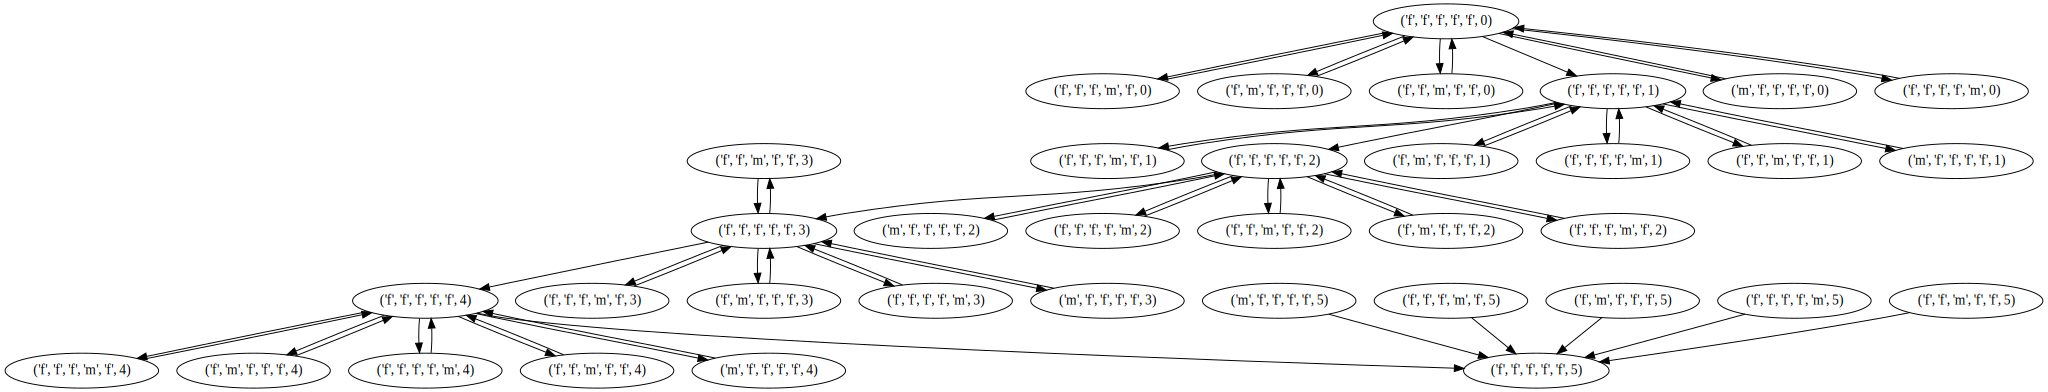

In [20]:
from pkg.utils.graph_visualize import *

vg = VisualGraph()

def simplify_node(node):
    return tuple([ntem[0] if isinstance(ntem, str) else ntem for ntem in node])

for node, leafs in inc.node_dict.items():
    vg.add_node(simplify_node(node), [simplify_node(leaf) for leaf in leafs])
    
gv = vg.draw()
# gv.save()
gv

## TODO
### data
* 인식 결과 샘플 저장

### Detector
* 첫 인식에서 캐리어 4개만 인식됨 (다시 인식하면 5개 나옴)
* 마커 인식 추가

### Planner
* 바퀴가 자꾸 멈춤 - 강제로 정지되면 다이나믹셀이 셧다운 됨 - 펌웨어 수정 필요
* 플래닝 성능 개선

### Anydesk 자동 연결 설정 (소형 모니터 연결?)

